### 128x128 CNN with random inputs

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
class CNN(layers.Layer):
    def __init__(self, units, kernel_size, strides, padding):
        super(CNN, self).__init__()
        self.cnn = layers.Conv2D(filters=units, kernel_size=kernel_size, strides=strides, padding=padding)
        self.bn = layers.BatchNormalization()
    
    def call(self, x, training=False):
        x = self.cnn(x)
        x = self.bn(x, training=training)
        x = tf.nn.relu(x)
        return x

In [3]:
class model128(keras.Model):
    def __init__(self):
        super(model128, self).__init__()
        self.layer1 = CNN(units=192, kernel_size=1, strides=1, padding='same')
        self.layer2 = layers.MaxPool2D(pool_size=(2, 2))
        self.layer3 = layers.Dropout(rate=0.3)
        self.layer4 = CNN(units=120, kernel_size=3, strides=1, padding='same')
        self.layer5 = layers.MaxPool2D(pool_size=(2, 2))
        self.layer6 = CNN(units=90, kernel_size=3, strides=1, padding='same')
        self.layer7 = layers.MaxPool2D(pool_size=(2, 2))
        self.layer8 = CNN(units=75, kernel_size=3, strides=1, padding='same')
        self.layer9 = layers.MaxPool2D(pool_size=(2, 2))
        self.flatten = layers.Flatten()
        self.layer10 = layers.Dense(units=512, activation='sigmoid')
        self.layer11 = layers.Dropout(rate=0.3)
        self.layer12 = layers.Dense(units=1, activation='sigmoid')
    
    def call(self, x, training=False):
        x = self.layer1(x, training=training)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x, training=training)
        x = self.layer5(x)
        x = self.layer6(x, training=training)
        x = self.layer7(x)
        x = self.layer8(x, training=training)
        x = self.layer9(x)
        x = self.flatten(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        return x

    def model(self):
        x = keras.Input(shape=(32, 32, 3))
        return keras.Model(inputs=[x], outputs=[self.call(x)])

In [4]:
model = model128()
model.model().summary()

Metal device set to: Apple M1
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 cnn (CNN)                   (None, 32, 32, 192)       1536      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 192)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 192)       0         
                                                                 
 cnn_1 (CNN)                 (None, 16, 16, 120)       207960    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 120)        0         
 2D)                           

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255.,
    shear_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=0.3,
    validation_split=0.1
)

test_datagen = ImageDataGenerator(
    rescale=1/255.
)

In [6]:
train_dataset = train_datagen.flow_from_directory(
    directory='../../data/train/',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=32,
    subset='training'
)

val_dataset = train_datagen.flow_from_directory(
    directory='../../data/train/',
    target_size=(128, 128),
    class_mode='binary',
    batch_size=32,
    subset='validation'
)

test_dataset = test_datagen.flow_from_directory(
    directory='../../data/test/',
    target_size=(128, 128),
    class_mode='binary'
)

Found 2374 images belonging to 2 classes.
Found 263 images belonging to 2 classes.
Found 660 images belonging to 2 classes.


In [7]:
model = model128()
model.compile(optimizer=tf.keras.optimizers.Adagrad(), loss='binary_crossentropy', 
             metrics=[
                 tf.keras.metrics.AUC(),
                 tf.keras.metrics.FalseNegatives(),
                 tf.keras.metrics.FalsePositives(),
                 tf.keras.metrics.Precision(),
                 tf.keras.metrics.Recall(),
                 'accuracy'
             ])
history = model.fit(train_dataset, 
                    epochs=100, 
                    validation_data=val_dataset, 
                    steps_per_epoch=len(train_dataset),
                    validation_steps=len(val_dataset))

Epoch 1/100
75/75 [==============================] - 40s 488ms/step - loss: 0.5743 - auc: 0.7671 - false_negatives: 408.0000 - false_positives: 318.0000 - precision: 0.6781 - recall: 0.6215 - accuracy: 0.6942 - val_loss: 0.6977 - val_auc: 0.7389 - val_false_negatives: 119.0000 - val_false_positives: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.5475
Epoch 2/100
75/75 [==============================] - 35s 466ms/step - loss: 0.4630 - auc: 0.8617 - false_negatives: 251.0000 - false_positives: 280.0000 - precision: 0.7471 - recall: 0.7672 - accuracy: 0.7763 - val_loss: 0.7220 - val_auc: 0.8387 - val_false_negatives: 119.0000 - val_false_positives: 0.0000e+00 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_accuracy: 0.5475
Epoch 3/100
75/75 [==============================] - 34s 460ms/step - loss: 0.4442 - auc: 0.8720 - false_negatives: 244.0000 - false_positives: 267.0000 - precision: 0.7575 - recall: 0.7737 - accuracy: 0.7848 - val_loss: 0.7

Epoch 23/100
75/75 [==============================] - 34s 458ms/step - loss: 0.3610 - auc: 0.9151 - false_negatives: 158.0000 - false_positives: 240.0000 - precision: 0.7931 - recall: 0.8534 - accuracy: 0.8324 - val_loss: 0.7174 - val_auc: 0.8499 - val_false_negatives: 109.0000 - val_false_positives: 1.0000 - val_precision: 0.9091 - val_recall: 0.0840 - val_accuracy: 0.5817
Epoch 24/100
75/75 [==============================] - 35s 465ms/step - loss: 0.3662 - auc: 0.9134 - false_negatives: 161.0000 - false_positives: 256.0000 - precision: 0.7818 - recall: 0.8506 - accuracy: 0.8243 - val_loss: 0.6532 - val_auc: 0.8505 - val_false_negatives: 102.0000 - val_false_positives: 3.0000 - val_precision: 0.8500 - val_recall: 0.1429 - val_accuracy: 0.6008
Epoch 25/100
75/75 [==============================] - 35s 473ms/step - loss: 0.3608 - auc: 0.9159 - false_negatives: 172.0000 - false_positives: 230.0000 - precision: 0.7975 - recall: 0.8404 - accuracy: 0.8307 - val_loss: 0.6252 - val_auc: 0.8548

Epoch 45/100
75/75 [==============================] - 34s 458ms/step - loss: 0.3262 - auc: 0.9327 - false_negatives: 141.0000 - false_positives: 220.0000 - precision: 0.8099 - recall: 0.8692 - accuracy: 0.8479 - val_loss: 0.7015 - val_auc: 0.8675 - val_false_negatives: 99.0000 - val_false_positives: 1.0000 - val_precision: 0.9524 - val_recall: 0.1681 - val_accuracy: 0.6198
Epoch 46/100
75/75 [==============================] - 34s 452ms/step - loss: 0.3236 - auc: 0.9347 - false_negatives: 156.0000 - false_positives: 206.0000 - precision: 0.8174 - recall: 0.8553 - accuracy: 0.8475 - val_loss: 0.7184 - val_auc: 0.8552 - val_false_negatives: 94.0000 - val_false_positives: 3.0000 - val_precision: 0.8929 - val_recall: 0.2101 - val_accuracy: 0.6312
Epoch 47/100
75/75 [==============================] - 34s 457ms/step - loss: 0.3274 - auc: 0.9316 - false_negatives: 157.0000 - false_positives: 204.0000 - precision: 0.8187 - recall: 0.8544 - accuracy: 0.8479 - val_loss: 0.6873 - val_auc: 0.8643 -

Epoch 67/100
75/75 [==============================] - 34s 453ms/step - loss: 0.3001 - auc: 0.9442 - false_negatives: 135.0000 - false_positives: 197.0000 - precision: 0.8272 - recall: 0.8748 - accuracy: 0.8602 - val_loss: 0.6538 - val_auc: 0.8600 - val_false_negatives: 82.0000 - val_false_positives: 7.0000 - val_precision: 0.8409 - val_recall: 0.3109 - val_accuracy: 0.6616
Epoch 68/100
75/75 [==============================] - 34s 454ms/step - loss: 0.2994 - auc: 0.9444 - false_negatives: 146.0000 - false_positives: 189.0000 - precision: 0.8314 - recall: 0.8646 - accuracy: 0.8589 - val_loss: 0.6636 - val_auc: 0.8641 - val_false_negatives: 84.0000 - val_false_positives: 6.0000 - val_precision: 0.8537 - val_recall: 0.2941 - val_accuracy: 0.6578
Epoch 69/100
75/75 [==============================] - 35s 468ms/step - loss: 0.2997 - auc: 0.9442 - false_negatives: 136.0000 - false_positives: 181.0000 - precision: 0.8388 - recall: 0.8738 - accuracy: 0.8665 - val_loss: 0.6290 - val_auc: 0.8632 -

Epoch 89/100
75/75 [==============================] - 34s 448ms/step - loss: 0.2793 - auc: 0.9525 - false_negatives: 115.0000 - false_positives: 172.0000 - precision: 0.8485 - recall: 0.8933 - accuracy: 0.8791 - val_loss: 0.6327 - val_auc: 0.8695 - val_false_negatives: 76.0000 - val_false_positives: 7.0000 - val_precision: 0.8600 - val_recall: 0.3613 - val_accuracy: 0.6844
Epoch 90/100
75/75 [==============================] - 34s 448ms/step - loss: 0.2804 - auc: 0.9516 - false_negatives: 124.0000 - false_positives: 152.0000 - precision: 0.8626 - recall: 0.8850 - accuracy: 0.8837 - val_loss: 0.6479 - val_auc: 0.8628 - val_false_negatives: 78.0000 - val_false_positives: 8.0000 - val_precision: 0.8367 - val_recall: 0.3445 - val_accuracy: 0.6730
Epoch 91/100
75/75 [==============================] - 34s 447ms/step - loss: 0.2818 - auc: 0.9507 - false_negatives: 130.0000 - false_positives: 175.0000 - precision: 0.8442 - recall: 0.8794 - accuracy: 0.8715 - val_loss: 0.5854 - val_auc: 0.8621 -

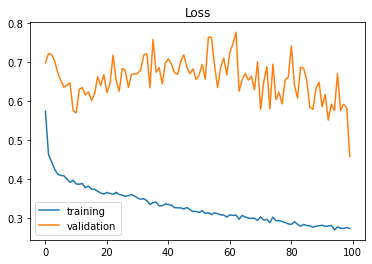

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend();

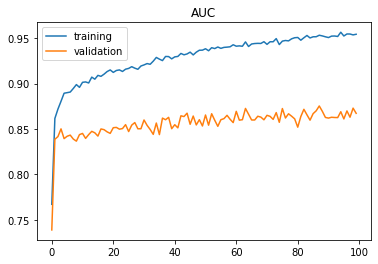

In [9]:
plt.figure()
plt.plot(history.history['auc'], label='training')
plt.plot(history.history['val_auc'], label='validation')
plt.title('AUC')
plt.legend();

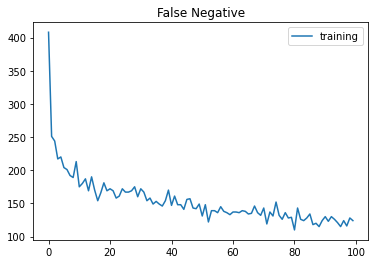

In [10]:
plt.figure()
plt.plot(history.history['false_negatives'], label='training')
plt.title('False Negative')
plt.legend();

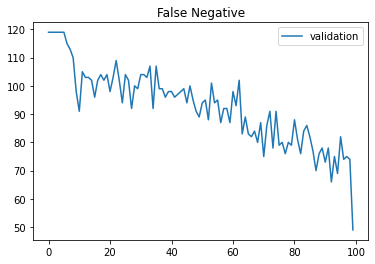

In [11]:
plt.figure()
plt.plot(history.history['val_false_negatives'], label='validation')
plt.title('False Negative')
plt.legend();

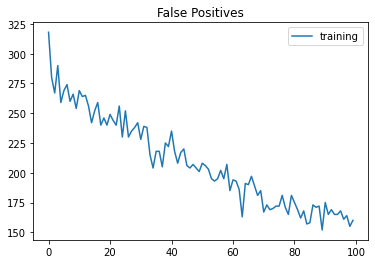

In [12]:
plt.figure()
plt.plot(history.history['false_positives'], label='training')
plt.title('False Positives')
plt.legend();

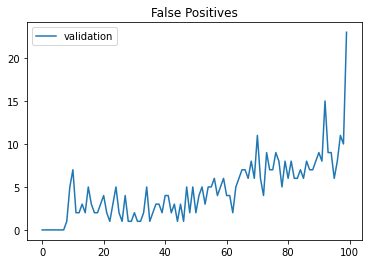

In [13]:
plt.figure()
plt.plot(history.history['val_false_positives'], label='validation')
plt.title('False Positives')
plt.legend();

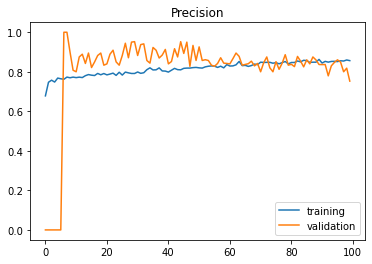

In [14]:
plt.figure()
plt.plot(history.history['precision'], label='training')
plt.plot(history.history['val_precision'], label='validation')
plt.title('Precision')
plt.legend();

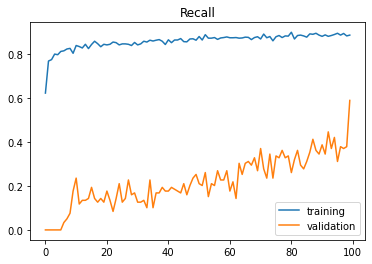

In [15]:
plt.figure()
plt.plot(history.history['recall'], label='training')
plt.plot(history.history['val_recall'], label='validation')
plt.title('Recall')
plt.legend();

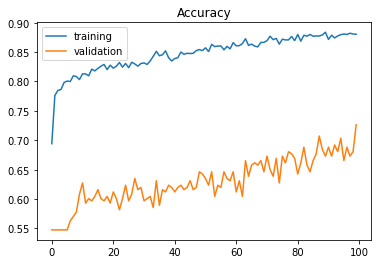

In [16]:
plt.figure()
plt.plot(history.history['accuracy'], label='training')
plt.plot(history.history['val_accuracy'], label='validation')
plt.title('Accuracy')
plt.legend();

In [ ]:
model.evaluate(train_dataset)

In [ ]:
model.evaluate(val_dataset)

In [ ]:
model.evaluate(test_dataset)